# Pre-Process for the Bearing Fault Dataset from CWRU

The data source is obtained from Bearing Data Center of Case Western Researve University https://engineering.case.edu/bearingdatacenter/download-data-file
## Data Description
We will take drive end data acquired at a sampling frequency of 48 kHz. The load on the shaft is 1 hp. For this load, there are 10 fault classes:
* C0 : Normal
* C1 : Ball defect (0.007 inch)
* C2 : Ball defect (0.014 inch)
* C3 : Ball defect (0.021 inch)
* C4 : Inner race fault (0.007 inch)
* C5 : Inner race fault (0.014 inch)
* C6 : Inner race fault (0.021 inch)
* C7 : Outer race fault (0.007 inch, data collected from 6 O'clock position)
* C8 : Outer race fault (0.014 inch, 6 O'clock)
* C9 : Outer race fault (0.021 inch, 6 O'clock)

In [8]:
import pandas as pd
import scipy.io as sio
import urllib.request as urq

### Download mat data and process them
More infomration about the CWRU data introduction can be found in https://engineering.case.edu/bearingdatacenter/download-data-file

In [27]:
import os

da_path = 'CWRU_Data'
if not os.path.exists(da_path):
  # Create a new directory because it does not exist 
  os.makedirs(da_path)

In [28]:
mat_fname = da_path+"//normal.mat"
urq.urlretrieve("https://engineering.case.edu/sites/default/files/98.mat", mat_fname)

('CWRU_Data//normal.mat', <http.client.HTTPMessage at 0x1b6e1d78f48>)

In [29]:
mat_contents = sio.loadmat(mat_fname)
print(mat_contents)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Jan 28 10:52:35 2000', '__version__': '1.0', '__globals__': [], 'X098_DE_time': array([[ 0.046104  ],
       [-0.03713354],
       [-0.089496  ],
       ...,
       [-0.09909231],
       [-0.10827138],
       [-0.07092923]]), 'X098_FE_time': array([[ 0.02321636],
       [ 0.08115455],
       [ 0.09533091],
       ...,
       [-0.00760182],
       [ 0.04026909],
       [ 0.06102   ]])}


In [34]:
np_normal = mat_contents['X098_DE_time']
print(len(np_normal))

483903


##### Segregating the data and conduct order analysis

In [40]:
import matplotlib.pyplot as plt
fs = 1/48000
rpm = 1772
t_axis = [fs*i for i in range(len(np_normal))]

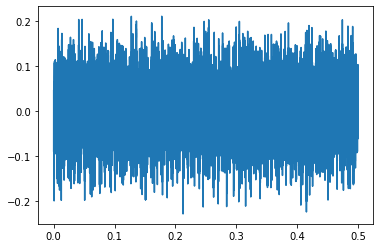

In [48]:
len_fft = int(1/fs/2)
plt.plot(t_axis[:len_fft],np_normal[:len_fft])

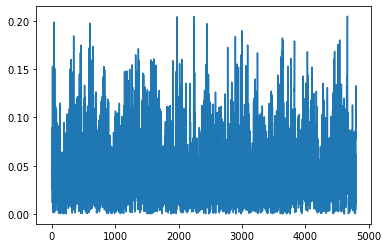

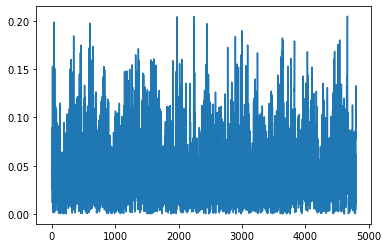

In [99]:
from scipy import fft
from scipy.signal import savgol_filter
import numpy as np
len_fft = 4800
yf = np.fft.fft(np_normal[:len_fft])
yft2 = fft(np_normal[:len_fft])
xf = np.fft.fftfreq(len_fft, fs)
plt.plot(np.abs(yf))
plt.figure()
plt.plot(savgol_filter( x=np.abs(yf), window_length=71, polyorder=7, mode='wrap'))

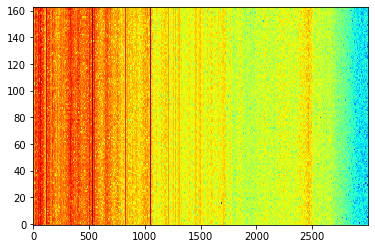

In [109]:
# data = a numpy array containing the signal to be processed
# fs = a scalar which is the sampling frequency of the data

fft_size = 3000
data = np_normal.flatten()
fs = 1/48000
overlap_fac = 0.01
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)
 
window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size
 
proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result
 
for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    result[i, :] = autopower[:fft_size]               # append to the results array
 
result = 20*np.log10(result)          # scale to db
# result = np.clip(result, -40, 200)    # clip values
img = plt.imshow(result, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.show()